In [2]:
import numpy as np
import re
from scipy import sparse
import scipy as sp

In [3]:
import pandas as pd 
rawdata = pd.read_csv("/Users/bailujia/Desktop/NLP/侵权.csv",encoding="UTF-8")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
featuredata = pd.read_excel('/Users/bailujia/Desktop/NLP/feature.xlsx',encoding="GBK")

In [5]:
featuredata.columns

Index(['庭审程序_是否_刑罚变更', '庭审程序_是否_一审', '庭审程序_是否_二审', '庭审程序_是否_复核', '庭审程序_是否_其他',
       '第三人_有无自然人', '原告_是否_检察院', '原告_是否_法人', '原告_是否_自然人', '原告_是否_其他',
       '庭审过程_是否拒不到庭_否', '庭审过程_是否拒不到庭_未知', '庭审过程_是否拒不到庭_汇总', '庭审过程_是否有异议_是',
       '庭审过程_是否有异议_否', '庭审过程_是否有异议_未知', '庭审过程_是否有异议_汇总', '庭审过程_长度', '法院等级',
       '被告_是否_自然人', '被告_是否_法人', '被告_是否_其他', '是否终审(y)'],
      dtype='object')

### Building feature matrix

In [9]:
user = featuredata[['第三人_有无自然人','原告_是否_检察院', '原告_是否_法人', '原告_是否_自然人', '原告_是否_其他',
                   '法院等级','被告_是否_自然人', '被告_是否_法人', '被告_是否_其他']]

In [10]:
case = rawdata['案由']

In [12]:
caseE = pd.read_csv("/Users/bailujia/Desktop/NLP/caseE.csv",encoding="UTF-8")

In [13]:
sparselaw = sparse.load_npz('/Users/bailujia/Desktop/NLP/sparselaw.npz')

In [14]:
denselaw = sparselaw.todense()

In [15]:
denselaw.shape

(58993, 482)

In [16]:
denselaw1  = pd.DataFrame(denselaw)
denselaw1['freq'] = denselaw1.apply(lambda x: x.sum(),axis=1)

In [17]:
indices = (denselaw1['freq'] > 1)
newfeature = pd.concat([caseE,user],axis = 1)
newfeature = newfeature.loc[indices]
denselaw1 = denselaw1.drop(columns =['freq'] )
newlaw = denselaw1.loc[indices]


In [95]:
newlaw[newlaw > 0] = 1

In [96]:
newfeature.shape

(30786, 49)

In [97]:
from skmultilearn.problem_transform import BinaryRelevance,LabelPowerset,ClassifierChain
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(newfeature, newlaw, test_size=0.33, random_state=42)

In [98]:
X_train1 = sparse.lil_matrix(X_train)
X_test1 =  sparse.lil_matrix(X_test)
y_train1 = sparse.lil_matrix(y_train)
y_test1 = sparse.lil_matrix(y_test)

### 模型一

In [99]:
import warnings

warnings.filterwarnings('ignore')

In [124]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(LogisticRegression())
# train
classifier.fit(X_train, y_train)

LabelPowerset(classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       require_dense=[True, True])

In [125]:
predictions = classifier.predict(X_test)

In [126]:
predictions[:10].todense()

matrix([[0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]])

In [127]:
relevantlaw = np.argsort(-newlaw.sum(axis=0))[:20]
Lawset4 = pd.read_csv('/Users/bailujia/Desktop/NLP/Lawset4.csv')
newlaw.columns = Lawset4['law']

In [128]:
from sklearn.metrics import accuracy_score,hamming_loss
sumac = 0
accuracy = []
hamm = []
for i in range((y_test.shape[0])):
    hamm.append(hamming_loss(y_test1[i,:].toarray().T,predictions[i,:].toarray().T))
for i in range(482):
    accuracy.append(accuracy_score(y_test.iloc[:,i],predictions[:,i].todense()))

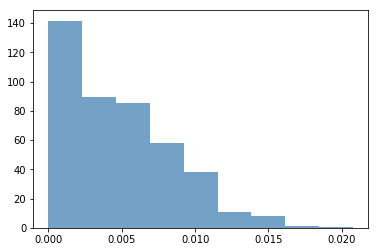

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(hamm, 9, density=True, facecolor='steelblue', alpha=0.75)
plt.show()

In [130]:
accuracy = np.array(accuracy)
pd.DataFrame(np.vstack([accuracy[relevantlaw],Lawset4['law'][relevantlaw]]).T,columns=["accuracy","law"])

,accuracy,law
0,0.994193,诉讼法
1,0.922539,交通安全法
2,0.813287,侵权责任法
3,0.754134,关于审理道路交通事故损害赔偿案件适用法律若干问题
4,0.647736,关于审理人身损害赔偿案件
5,0.525394,保险法
6,0.427067,机动车交通事故责任强制保险条例
7,0.872244,关于确定民事侵权精神损害赔偿责任若干问题
8,0.892224,民法通则
9,0.986614,食品安全法


In [131]:
result0 = pd.DataFrame(np.vstack([accuracy[relevantlaw],Lawset4['law'][relevantlaw]]).T,columns=["accuracy","law"])

In [132]:
result0.to_csv('/Users/bailujia/Desktop/NLP/mnbPlps.csv',index=False)

In [107]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.99 * (1 - .99)))
X_train2 = sel.fit_transform(X_train)
indicescol = sel.get_support()
X_test2 = X_test.iloc[:,indicescol]

In [108]:
X_train2.shape

(20626, 11)

### 模型二

In [109]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier,MajorityVotingClassifier
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder

graph_builder = LabelCooccurrenceGraphBuilder(weighted=True,
                                              include_self_edges=False)

label_names=[i for i in range(482)]
edge_map = graph_builder.transform(y_train1)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))

def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')


partition = clusterer.fit_predict(X_train1,y_train1)
membership_vector = to_membership_vector(partition)
print('There are', len(partition),'clusters')

482 labels, 1135 edges
There are 258 clusters


In [111]:
classifier = LabelSpacePartitioningClassifier(
    classifier = LabelPowerset(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
),
    clusterer  = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
)

X_train2 = sparse.lil_matrix(X_train2)
X_test2 = sparse.lil_matrix(X_test2)

classifier.fit(X_train2,y_train1)
y_hat = classifier.predict(X_test2)

In [112]:
y_hat.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [113]:
from sklearn.metrics import accuracy_score,confusion_matrix
sumac = 0
accuracy = []
hamm = []
CM = []
for i in range((y_test.shape[0])):
    hamm.append(hamming_loss(y_test1[i,:].toarray().T,y_hat[i,:].toarray().T))
for i in range(482):
    accuracy.append(accuracy_score(y_test.iloc[:,i],y_hat[:,i].todense()))
    CM.append(confusion_matrix(y_test.iloc[:,i],y_hat[:,i].todense()))

In [114]:
np.array(y_test).max()

1.0

In [115]:
for i in relevantlaw:
    print(Lawset4['law'][i],"\n", CM[i])

诉讼法 
 [[    0    59]
 [    0 10101]]
交通安全法 
 [[1436  747]
 [  40 7937]]
侵权责任法 
 [[ 970 1816]
 [  87 7287]]
关于审理道路交通事故损害赔偿案件适用法律若干问题 
 [[1773 2315]
 [ 186 5886]]
关于审理人身损害赔偿案件 
 [[6417   68]
 [3531  144]]
保险法 
 [[6721   24]
 [3408    7]]
机动车交通事故责任强制保险条例 
 [[7849   29]
 [2278    4]]
关于确定民事侵权精神损害赔偿责任若干问题 
 [[8856    6]
 [1297    1]]
民法通则 
 [[9057    7]
 [1095    1]]
食品安全法 
 [[9404  105]
 [  17  634]]
民事诉讼 
 [[9718    7]
 [ 428    7]]
最高人民法院关于适用的解释 
 [[9774   29]
 [ 328   29]]
合同法 
 [[9844    0]
 [ 316    0]]
机动车交通事故责任强制保险条款 
 [[9855    0]
 [ 305    0]]
最高人民法院关于审理食品药品纠纷案件适用法律若干问题的规定 
 [[10027    25]
 [   79    29]]
产品质量法 
 [[10068    23]
 [   60     9]]
诉讼费用交纳办法 
 [[10083    18]
 [   54     5]]
民法总则 
 [[10095     0]
 [   65     0]]
关于审理道路交通事故损害赔偿案件若干问题的解释 
 [[10109     0]
 [   51     0]]
消费者权益保护法 
 [[10100    19]
 [   27    14]]


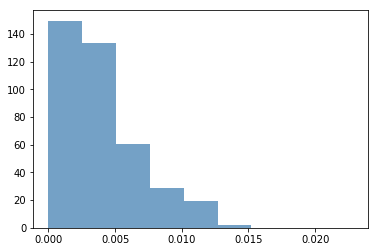

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(hamm, 9, density=True, facecolor='steelblue', alpha=0.75)
plt.show()

In [81]:
accuracy = np.array(accuracy)
result = pd.DataFrame(np.vstack([accuracy[relevantlaw],Lawset4['law'][relevantlaw]]).T,columns=["accuracy","law"])
print(result)

    accuracy                            law
0   0.974213                            诉讼法
1   0.918504                          交通安全法
2   0.812894                          侵权责任法
3   0.753839       关于审理道路交通事故损害赔偿案件适用法律若干问题
4   0.644882                   关于审理人身损害赔偿案件
5   0.662205                            保险法
6    0.77313                机动车交通事故责任强制保险条例
7    0.87185           关于确定民事侵权精神损害赔偿责任若干问题
8   0.891535                           民法通则
9   0.987795                          食品安全法
10  0.957185                           民事诉讼
11  0.965453                  最高人民法院关于适用的解释
12  0.968701                            合同法
13   0.96998                机动车交通事故责任强制保险条款
14  0.989764  最高人民法院关于审理食品药品纠纷案件适用法律若干问题的规定
15  0.991732                          产品质量法
16  0.994094                       诉讼费用交纳办法
17  0.993602                           民法总则
18   0.99498        关于审理道路交通事故损害赔偿案件若干问题的解释
19  0.995571                       消费者权益保护法


In [53]:
result.to_csv('/Users/bailujia/Desktop/NLP/lspPrf.csv',index=False)

In [68]:
X_train.shape

(20626, 49)

In [125]:
X_train.columns[sel.get_support()]

Index(['机动车交通事故责任纠纷', '侵权责任纠纷', '产品责任纠纷', '提供劳务者受害责任纠纷', '产品销售者责任纠纷',
       '原告_是否_法人', '原告_是否_自然人', '法院等级', '被告_是否_自然人', '被告_是否_法人', '被告_是否_其他'],
      dtype='object')

### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
accuracy = []
LogRegprediction = []
    
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
                ])
for category in range(482):
    print('**Processing {} comments...**'.format(category)) 
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train, y_train.iloc[:,category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test)
    LogRegprediction.append(prediction)
    accuracy.append(accuracy_score(y_test.iloc[:,category], prediction))

**Processing 0 comments...**
**Processing 1 comments...**
**Processing 2 comments...**
**Processing 3 comments...**
**Processing 4 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 5 comments...**
**Processing 6 comments...**
**Processing 7 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 8 comments...**
**Processing 9 comments...**
**Processing 10 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 11 comments...**
**Processing 12 comments...**
**Processing 13 comments...**
**Processing 14 comments...**
**Processing 15 comments...**
**Processing 16 comments...**
**Processing 17 comments...**
**Processing 18 comments...**
**Processing 19 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 20 comments...**
**Processing 21 comments...**
**Processing 22 comments...**
**Processing 23 comments...**
**Processing 24 comments...**
**Processing 25 comments...**
**Processing 26 comments...**
**Processing 27 comments...**
**Processing 28 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 29 comments...**
**Processing 30 comments...**
**Processing 31 comments...**
**Processing 32 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 33 comments...**
**Processing 34 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 35 comments...**
**Processing 36 comments...**
**Processing 37 comments...**
**Processing 38 comments...**
**Processing 39 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 40 comments...**
**Processing 41 comments...**
**Processing 42 comments...**
**Processing 43 comments...**
**Processing 44 comments...**
**Processing 45 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 46 comments...**
**Processing 47 comments...**
**Processing 48 comments...**
**Processing 49 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 50 comments...**
**Processing 51 comments...**
**Processing 52 comments...**
**Processing 53 comments...**
**Processing 54 comments...**
**Processing 55 comments...**
**Processing 56 comments...**
**Processing 57 comments...**
**Processing 58 comments...**
**Processing 59 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 60 comments...**
**Processing 61 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 62 comments...**
**Processing 63 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 64 comments...**
**Processing 65 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 66 comments...**
**Processing 67 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 68 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 69 comments...**
**Processing 70 comments...**
**Processing 71 comments...**
**Processing 72 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 73 comments...**
**Processing 74 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 75 comments...**
**Processing 76 comments...**
**Processing 77 comments...**
**Processing 78 comments...**
**Processing 79 comments...**
**Processing 80 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 81 comments...**
**Processing 82 comments...**
**Processing 83 comments...**
**Processing 84 comments...**
**Processing 85 comments...**
**Processing 86 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 87 comments...**
**Processing 88 comments...**
**Processing 89 comments...**
**Processing 90 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 91 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 92 comments...**
**Processing 93 comments...**
**Processing 94 comments...**
**Processing 95 comments...**
**Processing 96 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 97 comments...**
**Processing 98 comments...**
**Processing 99 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 100 comments...**
**Processing 101 comments...**
**Processing 102 comments...**
**Processing 103 comments...**
**Processing 104 comments...**
**Processing 105 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 106 comments...**
**Processing 107 comments...**
**Processing 108 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 109 comments...**
**Processing 110 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multi

**Processing 111 comments...**
**Processing 112 comments...**
**Processing 113 comments...**
**Processing 114 comments...**
**Processing 115 comments...**
**Processing 116 comments...**
**Processing 117 comments...**
**Processing 118 comments...**
**Processing 119 comments...**
**Processing 120 comments...**
**Processing 121 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 122 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 123 comments...**
**Processing 124 comments...**
**Processing 125 comments...**
**Processing 126 comments...**
**Processing 127 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 128 comments...**
**Processing 129 comments...**
**Processing 130 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 131 comments...**
**Processing 132 comments...**
**Processing 133 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 134 comments...**
**Processing 135 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 136 comments...**
**Processing 137 comments...**
**Processing 138 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 139 comments...**
**Processing 140 comments...**
**Processing 141 comments...**
**Processing 142 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 143 comments...**
**Processing 144 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 145 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 146 comments...**
**Processing 147 comments...**
**Processing 148 comments...**
**Processing 149 comments...**
**Processing 150 comments...**
**Processing 151 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 152 comments...**
**Processing 153 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 154 comments...**
**Processing 155 comments...**
**Processing 156 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 157 comments...**
**Processing 158 comments...**
**Processing 159 comments...**
**Processing 160 comments...**
**Processing 161 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 162 comments...**
**Processing 163 comments...**
**Processing 164 comments...**
**Processing 165 comments...**
**Processing 166 comments...**
**Processing 167 comments...**
**Processing 168 comments...**
**Processing 169 comments...**
**Processing 170 comments...**
**Processing 171 comments...**
**Processing 172 comments...**
**Processing 173 comments...**
**Processing 174 comments...**
**Processing 175 comments...**
**Processing 176 comments...**
**Processing 177 comments...**
**Processing 178 comments...**
**Processing 179 comments...**
**Processing 180 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all tr

**Processing 181 comments...**
**Processing 182 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 183 comments...**
**Processing 184 comments...**
**Processing 185 comments...**
**Processing 186 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 187 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 188 comments...**
**Processing 189 comments...**
**Processing 190 comments...**
**Processing 191 comments...**
**Processing 192 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 193 comments...**
**Processing 194 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 195 comments...**
**Processing 196 comments...**
**Processing 197 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 198 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 199 comments...**
**Processing 200 comments...**
**Processing 201 comments...**
**Processing 202 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 203 comments...**
**Processing 204 comments...**
**Processing 205 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 206 comments...**
**Processing 207 comments...**
**Processing 208 comments...**
**Processing 209 comments...**
**Processing 210 comments...**
**Processing 211 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 212 comments...**
**Processing 213 comments...**
**Processing 214 comments...**
**Processing 215 comments...**
**Processing 216 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 217 comments...**
**Processing 218 comments...**
**Processing 219 comments...**
**Processing 220 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 221 comments...**
**Processing 222 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 223 comments...**
**Processing 224 comments...**
**Processing 225 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 226 comments...**
**Processing 227 comments...**
**Processing 228 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 229 comments...**
**Processing 230 comments...**
**Processing 231 comments...**
**Processing 232 comments...**
**Processing 233 comments...**
**Processing 234 comments...**
**Processing 235 comments...**
**Processing 236 comments...**
**Processing 237 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all tr

**Processing 238 comments...**
**Processing 239 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 240 comments...**
**Processing 241 comments...**
**Processing 242 comments...**
**Processing 243 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 244 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 245 comments...**
**Processing 246 comments...**
**Processing 247 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 248 comments...**
**Processing 249 comments...**
**Processing 250 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 251 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 252 comments...**
**Processing 253 comments...**
**Processing 254 comments...**
**Processing 255 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 256 comments...**
**Processing 257 comments...**
**Processing 258 comments...**
**Processing 259 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 260 comments...**
**Processing 261 comments...**
**Processing 262 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 263 comments...**
**Processing 264 comments...**
**Processing 265 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 266 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 267 comments...**
**Processing 268 comments...**
**Processing 269 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 270 comments...**
**Processing 271 comments...**
**Processing 272 comments...**
**Processing 273 comments...**
**Processing 274 comments...**
**Processing 275 comments...**
**Processing 276 comments...**
**Processing 277 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 278 comments...**
**Processing 279 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 280 comments...**
**Processing 281 comments...**
**Processing 282 comments...**
**Processing 283 comments...**
**Processing 284 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 285 comments...**
**Processing 286 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 287 comments...**
**Processing 288 comments...**
**Processing 289 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 290 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multi

**Processing 291 comments...**
**Processing 292 comments...**
**Processing 293 comments...**
**Processing 294 comments...**
**Processing 295 comments...**
**Processing 296 comments...**
**Processing 297 comments...**
**Processing 298 comments...**
**Processing 299 comments...**
**Processing 300 comments...**
**Processing 301 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 302 comments...**
**Processing 303 comments...**
**Processing 304 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 305 comments...**
**Processing 306 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 307 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 308 comments...**
**Processing 309 comments...**
**Processing 310 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 311 comments...**
**Processing 312 comments...**
**Processing 313 comments...**
**Processing 314 comments...**
**Processing 315 comments...**
**Processing 316 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 317 comments...**
**Processing 318 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 319 comments...**
**Processing 320 comments...**
**Processing 321 comments...**
**Processing 322 comments...**
**Processing 323 comments...**
**Processing 324 comments...**
**Processing 325 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 326 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 327 comments...**
**Processing 328 comments...**
**Processing 329 comments...**
**Processing 330 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 331 comments...**
**Processing 332 comments...**
**Processing 333 comments...**
**Processing 334 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 335 comments...**
**Processing 336 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 337 comments...**
**Processing 338 comments...**
**Processing 339 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 340 comments...**
**Processing 341 comments...**
**Processing 342 comments...**
**Processing 343 comments...**
**Processing 344 comments...**
**Processing 345 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 346 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 347 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 348 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 349 comments...**
**Processing 350 comments...**
**Processing 351 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 352 comments...**
**Processing 353 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 354 comments...**
**Processing 355 comments...**
**Processing 356 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 357 comments...**
**Processing 358 comments...**
**Processing 359 comments...**
**Processing 360 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 361 comments...**
**Processing 362 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 363 comments...**
**Processing 364 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 365 comments...**
**Processing 366 comments...**
**Processing 367 comments...**
**Processing 368 comments...**
**Processing 369 comments...**
**Processing 370 comments...**
**Processing 371 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 372 comments...**
**Processing 373 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 374 comments...**
**Processing 375 comments...**
**Processing 376 comments...**
**Processing 377 comments...**
**Processing 378 comments...**
**Processing 379 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 380 comments...**
**Processing 381 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 382 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 383 comments...**
**Processing 384 comments...**
**Processing 385 comments...**
**Processing 386 comments...**
**Processing 387 comments...**
**Processing 388 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 389 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 390 comments...**
**Processing 391 comments...**
**Processing 392 comments...**
**Processing 393 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 394 comments...**
**Processing 395 comments...**
**Processing 396 comments...**
**Processing 397 comments...**
**Processing 398 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 399 comments...**
**Processing 400 comments...**
**Processing 401 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 402 comments...**
**Processing 403 comments...**
**Processing 404 comments...**
**Processing 405 comments...**
**Processing 406 comments...**
**Processing 407 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 408 comments...**
**Processing 409 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 410 comments...**
**Processing 411 comments...**
**Processing 412 comments...**
**Processing 413 comments...**
**Processing 414 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 415 comments...**
**Processing 416 comments...**
**Processing 417 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 418 comments...**
**Processing 419 comments...**
**Processing 420 comments...**
**Processing 421 comments...**
**Processing 422 comments...**
**Processing 423 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multi

**Processing 424 comments...**
**Processing 425 comments...**
**Processing 426 comments...**
**Processing 427 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 428 comments...**
**Processing 429 comments...**
**Processing 430 comments...**
**Processing 431 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 432 comments...**
**Processing 433 comments...**
**Processing 434 comments...**
**Processing 435 comments...**
**Processing 436 comments...**
**Processing 437 comments...**
**Processing 438 comments...**
**Processing 439 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 440 comments...**
**Processing 441 comments...**
**Processing 442 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 443 comments...**
**Processing 444 comments...**
**Processing 445 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 446 comments...**
**Processing 447 comments...**
**Processing 448 comments...**
**Processing 449 comments...**
**Processing 450 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 451 comments...**
**Processing 452 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 453 comments...**
**Processing 454 comments...**
**Processing 455 comments...**
**Processing 456 comments...**
**Processing 457 comments...**
**Processing 458 comments...**
**Processing 459 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multi

**Processing 460 comments...**
**Processing 461 comments...**
**Processing 462 comments...**
**Processing 463 comments...**
**Processing 464 comments...**
**Processing 465 comments...**
**Processing 466 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 467 comments...**
**Processing 468 comments...**
**Processing 469 comments...**
**Processing 470 comments...**
**Processing 471 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Processing 472 comments...**
**Processing 473 comments...**
**Processing 474 comments...**
**Processing 475 comments...**
**Processing 476 comments...**


/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


**Processing 477 comments...**
**Processing 478 comments...**
**Processing 479 comments...**
**Processing 480 comments...**
**Processing 481 comments...**


In [40]:
LogRegprediction = np.array(LogRegprediction).T
hamm = []
for i in range((y_test.shape[0])):
    hamm.append(hamming_loss(y_test1[i,:].toarray().T,LogRegprediction[i,:].T))

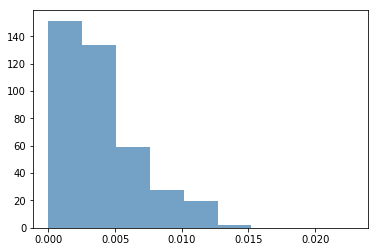

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(hamm, 9, density=True, facecolor='steelblue', alpha=0.75)
plt.show()

In [140]:
accuracy = np.array(accuracy)
result = pd.DataFrame(np.vstack([accuracy[relevantlaw],Lawset4['law'][relevantlaw]]).T,columns=["accuracy","law"])
print(result)

    accuracy                                law
0   0.974705                                诉讼法
1   0.918701                              交通安全法
2   0.812402                              侵权责任法
3   0.754035           关于审理道路交通事故损害赔偿案件适用法律若干问题
4   0.648031                       关于审理人身损害赔偿案件
5   0.663878                                保险法
6   0.775394                    机动车交通事故责任强制保险条例
7   0.872244               关于确定民事侵权精神损害赔偿责任若干问题
8   0.892126                               民法通则
9   0.987402                              食品安全法
10  0.957185                               民事诉讼
11  0.963976                      最高人民法院关于适用的解释
12  0.968898                                合同法
13   0.96998                    机动车交通事故责任强制保险条款
14  0.989961      最高人民法院关于审理食品药品纠纷案件适用法律若干问题的规定
15  0.993209                              产品质量法
16  0.993701                           诉讼费用交纳办法
17  0.993602                               民法总则
18   0.99498            关于审理道路交通事故损害赔偿案件若干问题的解释
19  0.995965                           消

#### MLkNN

In [133]:
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=20)
# train
classifier.fit(X_train1, y_train1)
# predict
predictions = classifier.predict(X_test1)

In [134]:
from sklearn.metrics import accuracy_score,hamming_loss
sumac = 0
accuracy = []
hamm = []
for i in range((y_test.shape[0])):
    hamm.append(hamming_loss(y_test1[i,:].toarray().T,predictions[i,:].toarray().T))
for i in range(482):
    accuracy.append(accuracy_score(y_test.iloc[:,i],predictions[:,i].todense()))

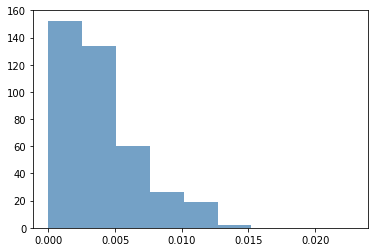

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(hamm, 9, density=True, facecolor='steelblue', alpha=0.75)
plt.show()

In [136]:
accuracy = np.array(accuracy)
pd.DataFrame(np.vstack([accuracy[relevantlaw],Lawset4['law'][relevantlaw]]).T,columns=["accuracy","law"])

,accuracy,law
0,0.994193,诉讼法
1,0.920965,交通安全法
2,0.813681,侵权责任法
3,0.746949,关于审理道路交通事故损害赔偿案件适用法律若干问题
4,0.647047,关于审理人身损害赔偿案件
5,0.663878,保险法
6,0.775394,机动车交通事故责任强制保险条例
7,0.872244,关于确定民事侵权精神损害赔偿责任若干问题
8,0.892126,民法通则
9,0.987795,食品安全法
